In [1]:
#create config
from dataclasses import dataclass

@dataclass
class Config: 
    target_shape = None # will transform t1n during preprocessing (computationally expensive)
    unet_img_shape = (256,256)
    channels = 1
    effective_train_batch_size=32 
    eval_batch_size = 16 
    sorted_slice_sample_size = 1
    num_dataloader_workers = 8
    num_epochs = 300 # one epoch needs ~12min (x2 GPU), because their are more training samples due connected_components
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500 #500
    evaluate_epochs = 5
    deactivate2Devaluation = False
    deactivate3Devaluation = True
    evaluate_num_batches = 15 # one batch needs ~15s.  
    evaluate_num_batches_3d = 2
    evaluate_unconditional_img = False
    evaluate_3D_epochs = 1000  # one 3D evaluation needs ~20min 
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-cond-lesions"  # the model name locally and on the HF Hub
    dataset_train_path = "./datasets/filling/dataset_train/imgs"
    segm_train_path = "./datasets/filling/dataset_train/segm"
    masks_train_path = "./datasets/filling/dataset_train/masks"
    dataset_eval_path = "./datasets/filling/dataset_eval/imgs"
    segm_eval_path = "./datasets/filling/dataset_eval/segm"
    masks_eval_path = "./datasets/filling/dataset_eval/masks" 
    train_connected_masks=True
    eval_connected_masks=False
    num_inference_steps=50
    log_csv = False
    mode = "train" # train / eval
    debug = True
    brightness_augmentation = True
    restrict_mask_to_wm=True
    proportion_training_circular_masks = 0.0
    eval_loss_timesteps=[20,80,140,200,260,320,380,440,560,620,680,740,800,860,920,980]
    restrict_train_slices = "mask"
    restrict_eval_slices = "mask"
    use_min_snr_loss=False
    snr_gamma=5

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = Config()

In [2]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)
#if there are problems with ports then add manually "main_process_port: 0" or another number to yaml file

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [3]:
from pathlib import Path
import json
with open(Path.home() / ".cache/huggingface/accelerate/default_config.yaml") as f:
    data = json.load(f)
    config.num_processes = data["num_processes"]

In [4]:
config.train_batch_size = int((config.effective_train_batch_size / config.gradient_accumulation_steps) / config.num_processes)

In [5]:
if config.debug:
    config.num_inference_steps=1
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.eval_loss_timesteps = [20]
    config.train_connected_masks=False
    config.eval_connected_masks=False
    config.evaluate_num_batches=1
    config.dataset_train_path = "./datasets/filling/dataset_eval/imgs"
    config.segm_train_path = "./datasets/filling/dataset_eval/segm"
    config.masks_train_path = "./datasets/filling/dataset_eval/masks"
    config.num_dataloader_workers = 1

In [6]:
print(f"Start training with batch size {config.train_batch_size}, {config.gradient_accumulation_steps} accumulation steps and {config.num_processes} process(es)")

Start training with batch size 1, 1 accumulation steps and 1 process(es)


In [7]:
from custom_modules import DatasetMRI2D, DatasetMRI3D, ScaleDecorator
from pathlib import Path
from torchvision import transforms 

#add augmentation
transformations = None
if config.brightness_augmentation:
    transformations = transforms.RandomApply([ScaleDecorator(transforms.ColorJitter(brightness=1))], p=0.5)

#create dataset
dataset_train = DatasetMRI2D(root_dir_img=Path(config.dataset_train_path), restriction=config.restrict_train_slices, root_dir_segm=Path(config.segm_train_path), root_dir_masks=Path(config.masks_train_path), connected_masks=config.train_connected_masks, target_shape=config.target_shape, transforms=transformations, restrict_mask_to_wm=config.restrict_mask_to_wm)
dataset_evaluation = DatasetMRI2D(root_dir_img=Path(config.dataset_eval_path), restriction=config.restrict_eval_slices, root_dir_masks=Path(config.masks_eval_path), connected_masks=config.eval_connected_masks, target_shape=config.target_shape)
dataset_3D_evaluation = DatasetMRI3D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), connected_masks=config.eval_connected_masks, target_shape=config.target_shape)

2024-06-14 11:57:14.669135: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 11:57:14.816610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 11:57:14.816671: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 11:57:14.816755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-14 11:57:14.853221: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 11:57:14.859527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### Visualize dataset

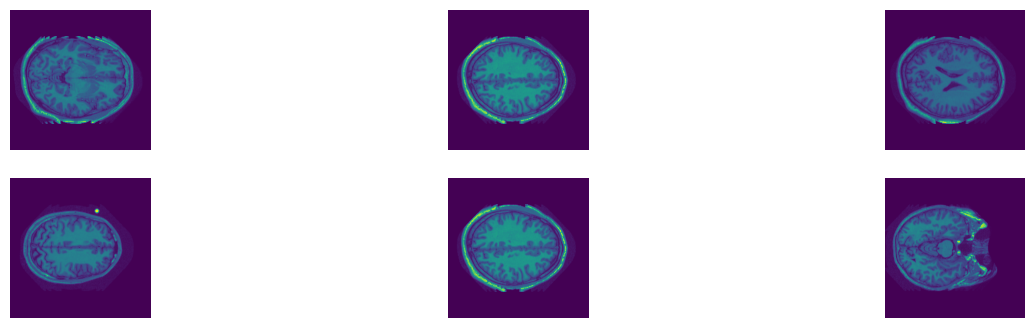

In [8]:
import matplotlib.pyplot as plt

# Get 6 random sample
random_indices = np.random.randint(0, len(dataset_train) - 1, size=(6)) 

# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((dataset_train[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

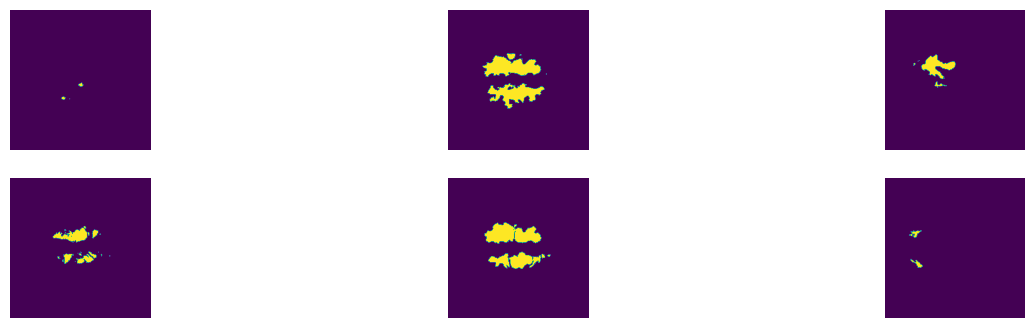

In [9]:
# Plot: masks
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(dataset_train[idx]["mask"].squeeze())
    axis[i//3,i%3].set_axis_off()
fig.show()

### Prepare Training

In [10]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.unet_img_shape,  # the target image resolution
    in_channels=3, # the number of input channels: 1 for img, 1 for img_voided, 1 for mask
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

config.model = "UNet2DModel"

In [11]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
#sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
#noise = torch.randn(sample_image.shape)
#timesteps = torch.LongTensor([50])
#noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

config.noise_scheduler = "DDIMScheduler(num_train_timesteps=1000)"

In [12]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(dataset_train)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

config.lr_scheduler = "cosine_schedule_with_warmup"

In [13]:
from accelerate import Accelerator 

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,  
)

In [14]:
from torch.utils.tensorboard import SummaryWriter
import os

if accelerator.is_main_process:
    if config.output_dir is not None:
        os.makedirs(config.output_dir, exist_ok=True) 
    #setup tensorboard
    tb_summary = SummaryWriter(config.output_dir, purge_step=0)
    accelerator.init_trackers("train_example") #maybe delete

In [15]:
if accelerator.is_main_process:
    from custom_modules import Logger
    logger = Logger(tb_summary, config.log_csv)
    logger.log_config(config)

In [16]:
from custom_modules import get_dataloader

train_dataloader = get_dataloader(dataset=dataset_train, batch_size = config.train_batch_size, 
                                  num_workers=config.num_dataloader_workers, random_sampler=True, 
                                  seed=config.seed, multi_slice=config.sorted_slice_sample_size > 1)
d2_eval_dataloader = get_dataloader(dataset=dataset_evaluation, batch_size = config.eval_batch_size, 
                                    num_workers=config.num_dataloader_workers, random_sampler=False, 
                                    seed=config.seed, multi_slice=config.sorted_slice_sample_size > 1)
d3_eval_dataloader = get_dataloader(dataset=dataset_3D_evaluation, batch_size = 1, 
                                    num_workers=config.num_dataloader_workers, random_sampler=False, 
                                    seed=config.seed, multi_slice=False) 

In [17]:
from custom_modules import ModelInputGenerator, Evaluation2DFilling, Evaluation3DFilling 

model_input_generator = ModelInputGenerator(conditional=True, noise_scheduler=noise_scheduler)
 
args = {
    "eval_dataloader": d2_eval_dataloader, 
    "train_dataloader": train_dataloader,
    "logger": None if not accelerator.is_main_process else logger, 
    "accelerator": accelerator,
    "num_inference_steps": config.num_inference_steps,
    "model_input_generator": model_input_generator,
    "output_dir": config.output_dir,
    "eval_loss_timesteps": config.eval_loss_timesteps, 
    "evaluate_num_batches": config.evaluate_num_batches, 
    "seed": config.seed
}
evaluation2D = Evaluation2DFilling(**args)
args = {
    "dataloader": d3_eval_dataloader, 
    "logger": None if not accelerator.is_main_process else logger, 
    "accelerator": accelerator,
    "output_dir": config.output_dir,
    "num_inference_steps": config.num_inference_steps,
    "eval_batch_size": config.eval_batch_size,
    "sorted_slice_sample_size": config.sorted_slice_sample_size,
    "evaluate_num_batches": config.evaluate_num_batches_3d,
    "seed": config.seed,
}
evaluation3D = Evaluation3DFilling(**args)

In [19]:
from custom_modules import Training, DDIMInpaintPipeline, Evaluation2DFilling, Evaluation3DFilling
from custom_modules import PipelineFactories

args = { 
    "accelerator": accelerator,
    "model": model, 
    "noise_scheduler": noise_scheduler, 
    "optimizer": optimizer, 
    "lr_scheduler": lr_scheduler,
    "train_dataloader": train_dataloader, 
    "d2_eval_dataloader": d2_eval_dataloader, 
    "d3_eval_dataloader": d3_eval_dataloader, 
    "model_input_generator": model_input_generator,
    "evaluation2D": evaluation2D,
    "evaluation3D": evaluation3D,
    "logger": None if not accelerator.is_main_process else logger,
    "pipeline_factory": PipelineFactories.get_ddim_inpaint_pipeline,
    "num_epochs": config.num_epochs, 
    "evaluate_2D_epochs": config.evaluate_epochs,
    "evaluate_3D_epochs": config.evaluate_3D_epochs,
    "min_snr_loss": config.use_min_snr_loss,
    "snr_gamma": config.snr_gamma,
    "evaluate_unconditional_img": config.evaluate_unconditional_img,
    "deactivate_2D_evaluation": config.deactivate2Devaluation, 
    "deactivate_3D_evaluation": config.deactivate3Devaluation, 
    "evaluation_pipeline_parameters": {},
    "debug": config.debug, 
    }
trainingLesions = Training(**args)

In [20]:
if config.mode == "train":
    trainingLesions.train()

  0%|          | 0/2152 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid 77535) is killed by signal: Killed. 

In [ ]:
if config.mode == "eval":
    trainingLesions.deactivate_3D_evaluation = False
    pipeline = DDIMInpaintPipeline.from_pretrained(config.output_dir) 
    trainingLesions.evaluate(pipeline, deactivate_save_model=True)

In [ ]:
print("Finished Training")

In [ ]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_conditioned_lesions.ipynb"
filename="lesion_filling_conditioned_lesions.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-18: 
            fp.write(line)
# Deactivate Debug!!!